Filter mappings between New York Times locations and weather stations. Check that distance between station and location "center" is acceptable for each element measured (rain, temperature ...). If not, set mapping to NULL.

In [34]:
from IPython.core.interactiveshell import InteractiveShell
# display output of all cell lines (not only the last one)
#InteractiveShell.ast_node_interactivity = "all"
InteractiveShell.ast_node_interactivity = "last_expr"
from IPython.display import display, HTML

In [47]:
import configparser
import os
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T

import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import date, timedelta
from sqlalchemy import create_engine


In [2]:
config = configparser.ConfigParser()
config.read("capstone.cfg")

['capstone.cfg']

In [3]:
project_path = config["PATH"]["project"]
os.chdir(project_path)

# Load mappings

In [4]:
# check multi index read ok 
out_name = os.path.join("OUT_DATA", "closest_stations.csv")
toto = pd.read_csv(out_name, index_col = [0,1])#, skipinitialspace=True)
toto

fips                      county state_gazeeter   station_id  \
SNOW 0     53061.0                   Snohomish     Washington  USW00094290   
     1     17031.0                        Cook       Illinois  USC00111577   
     2      6059.0                      Orange     California  US1CALA0092   
     3      4013.0                    Maricopa        Arizona  USW00023183   
     4      6037.0                 Los Angeles     California  US1CALA0001   
...            ...                         ...            ...          ...   
TAVG 3265      NaN                     Unknown          Idaho  USR0000IHPK   
     3266      NaN                     Unknown        Montana  USS0009C01S   
     3267      NaN                     Unknown         Alaska  USR0000ANOR   
     3268      NaN                     Unknown        Wyoming  USS0007F06S   
     3269   2261.0  Valdez-Cordova Census Area         Alaska  USS0046M04S   

                                           station_name state_station  \
SNOW 0     SEATTLE SAND PT WSFO                                    WA   
     1     CHICAGO MIDWAY AP 3SW                  72534            IL   
     2     REDONDO BEACH 2.1 SSW                                   CA   
     3     PHOENIX SKY HARBOR INTL AP     GSN     72278            AZ   
     4     GLENDALE 2.4 WSW                                        CA   
...                                                 ...           ...   
TAVG 3265  HORTON PEAK IDAHO                                       ID   
     3266  Crystal Lake                                            MT   
     3267  NORUTAK LAKE ALASKA                                     AK   
     3268  Grave Springs                                           WY   
     3269  Sugarloaf Mtn                                           AK   

           latitude_station  longitude_station   distance  
SNOW 0              47.6872          -122.2553  27.427372  
     1              41.7372           -87.7775  10.306315  
     2              33.8274          -118.3888  29.503349  
     3              33.4278          -112.0039  23.435202  
     4              34.1689          -118.2947   2.149035  
...                     ...                ...        ...  
TAVG 3265           43.9481          -114.7561   6.701040  
     3266           46.7900          -109.5100   9.785520  
     3267           66.8333          -154.3333  43.082228  
     3268           43.4700          -107.2400  22.001426  
     3269           61.0800          -146.3000   3.169607  

[19620 rows x 9 columns]

In [5]:
#titi = toto.groupby(level=0).apply(lambda toto: toto.xs(toto.name).to_dict()).to_dict()
# convert multiindex dataframe to dict

# all level 0 index values (i.e. weather elements)
l_weather_elements = toto.index.levels[0]
print(l_weather_elements)
# slice dataframe along elements and make put into dict

titi= { elem : toto.xs(elem) for elem in l_weather_elements }
titi["PRCP"].head()


Index(['PRCP', 'SNOW', 'SNWD', 'TAVG', 'TMAX', 'TMIN'], dtype='object')


,fips,county,state_gazeeter,station_id,station_name,state_station,latitude_station,longitude_station,distance
0,53061.0,Snohomish,Washington,US1WASN0091,LAKE STEVENS 3.2 N,WA,48.0637,-122.0575,10.878616
1,17031.0,Cook,Illinois,US1ILCK0074,OAK PARK 1.3 NNE,IL,41.9062,-87.7819,5.684991
2,6059.0,Orange,California,USC00044303,IRVINE RCH,CA,33.7200,-117.7231,3.511917
3,4013.0,Maricopa,Arizona,US1AZMR0170,GOODYEAR 5.9 WSW,AZ,33.4066,-112.4485,4.140580
4,6037.0,Los Angeles,California,US1CALA0001,GLENDALE 2.4 WSW,CA,34.1689,-118.2947,2.149035


In [6]:
for elem, lst in titi.items():
    print(elem, len(lst))

PRCP 3270
SNOW 3270
SNWD 3270
TAVG 3270
TMAX 3270
TMIN 3270


In [7]:
dfmi_closest_stations = toto
closest_stations_allinfo = titi

# Outlier analysis functions

In [163]:
def outlier_identification(df, element, distance_threshold = 100, bins = 100):
    # keep only rows for element
    df_elem = df.loc[element]
    display(df_elem.loc[:, "distance"].describe())
    # stations too far from location
    faraway_stations = df_elem[  df_elem.loc[:,"distance"]>distance_threshold ] 
    print(faraway_stations.shape)
    faraway_stations["distance"].hist(bins = bins)
#    plt.show()
    display( faraway_stations[[ "state_gazeeter", "state_station"]].value_counts().to_frame("counts").reset_index())
    
    group_outliers = faraway_stations[ ["state_gazeeter", "state_station", "distance"] ]\
        .groupby(["state_gazeeter", "state_station"])\
        .agg( {"distance" : [np.mean, np.median, min, max, len]} )\
        .reset_index()
 ##.sort_values(("distance", "len"), axis = 1)\
    display(group_outliers.columns)
    group_outliers.sort_values([("distance", "len")], inplace = True, ascending = False)
    display(group_outliers)
    return group_outliers

count    3270.000000
mean       39.104982
std       167.015503
min         0.034007
25%         4.992082
50%        10.530078
75%        18.543485
max      2989.364868
Name: distance, dtype: float64

(99, 9)


,state_gazeeter,state_station,counts
0,Puerto Rico,FL,78
1,Alaska,AK,10
2,Virgin Islands,FL,3
3,Hawaii,CA,3
4,Hawaii,AK,3
5,Northern Mariana Islands,AK,2


MultiIndex([('state_gazeeter',       ''),
            ( 'state_station',       ''),
            (      'distance',   'mean'),
            (      'distance', 'median'),
            (      'distance',    'min'),
            (      'distance',    'max'),
            (      'distance',    'len')],
           )

state_gazeeter state_station     distance               \
                                                  mean       median   
4               Puerto Rico            FL   829.760633   832.233799   
0                    Alaska            AK   209.624911   164.496379   
1                    Hawaii            AK  1831.544835  1837.397653   
2                    Hawaii            CA  1884.524023  1883.043157   
5            Virgin Islands            FL   903.117387   899.124199   
3  Northern Mariana Islands            AK  2981.368260  2981.368260   

                                   
           min          max   len  
4   770.309777   876.599394  78.0  
0   110.477210   516.924429  10.0  
1  1795.907377  1861.329474   3.0  
2  1880.790043  1889.738869   3.0  
5   892.708535   917.519426   3.0  
3  2973.371651  2989.364868   2.0

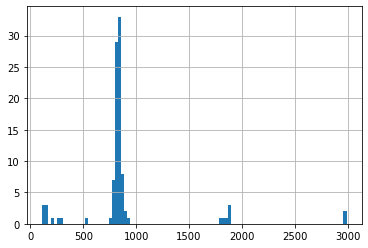

In [164]:
outliers_snow = outlier_identification(dfmi_closest_stations, "SNOW")

In [169]:
states_pairs = list(zip( outliers_snow["state_gazeeter"],  outliers_snow["state_station"] ))
states_pairs

[('Puerto Rico', 'FL'),
 ('Alaska', 'AK'),
 ('Hawaii', 'AK'),
 ('Hawaii', 'CA'),
 ('Virgin Islands', 'FL'),
 ('Northern Mariana Islands', 'AK')]